In [1]:
import os
import sys 
import numpy as np
import hypertools as hyp
from qmvpa import utils, factor
from data_loader import load_cifar, load_mnist
# from data_loader_local import load_data
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from config import get_log_info, get_layer_names_plt
from dep.utils import subset_units

import matplotlib.pyplot as plt 
import seaborn as sns 

sns.set(style = 'white', context='paper', rc={"lines.linewidth": 2.5}, font_scale = 1.5)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

log_root = '/tigress/qlu/logs/keras-resnet/log'

Using TensorFlow backend.


In [2]:
data_name = 'cifar100'
model_name = 'conv'

# load data 
_, _, _, _, _, labels, data_info = load_cifar(data_name)
[n_classes, img_rows, img_cols, img_channels] = data_info
n_test_egs = len(labels)

# define params 
log_info_list = get_log_info(data_name, model_name)
n_subjs, layer_selected, n_layers, log_epochs, n_log_epochs = log_info_list
layer_names_plt = get_layer_names_plt(model_name)

print('data: %s\nmodel: %s' % (data_name, model_name))
print('log epochs', log_epochs)
print('layer selected', layer_selected)


# set relevant parameters 
n_max_units = 1000
test_size = .2 

# plotting params 
temporal_window_size = 10
save_animation = True
n_nets_plot = 5

# choose layer and epoch 
e = 32
l = 13

data: cifar100
model: conv
log epochs [ 0.  1.  2.  4.  6.  9. 14. 21. 32. 50.]
layer selected [4, 10, 13, 16]


In [3]:
ss = StandardScaler()

# only test random network vs. fully trained network
# first and last epoch 
log_epochs = [log_epochs[0], log_epochs[-1]]
# first and last few layers
layer_to_plt = [0, -2, -1]
layer_selected = [layer_selected[l] for l in layer_to_plt]
layer_names_plt = [layer_names_plt[l] for l in layer_to_plt]

# e = 100
# l = 55  

# for e in log_epochs: 
#     for l in layer_selected:
print('Layer %d, Epoch %d' % (l, e))
# load data for all subjects 
Xs_train = []
Xs_test = []
for subj_id in range(n_subjs):
    # activation log dir 
    log_dir = os.path.join(log_root, data_name, model_name, 'subj%.2d' % (subj_id))
    acts_path = os.path.join(log_dir, 'epoch_%.3d' % e, 'activations')
    acts_path_l = os.path.join(acts_path, 'layer_%.3d.npy' % (l))

    # load activity 
    loaded_acts = np.load(acts_path_l)
    loaded_acts = np.reshape(loaded_acts, [n_test_egs, -1])

    # subset units for computational efficiency 
    n_units = np.shape(loaded_acts)[1]
    if n_units > n_max_units: 
        loaded_acts = subset_units(loaded_acts, n_max_units)

    # split to training and testing set 
    X = loaded_acts
    X_train, X_test, y_train, y_test = train_test_split(
        X, labels, test_size = test_size, stratify = labels, random_state=0
    )
    y_test_id = np.argsort(np.ravel(y_test))
    y_test = y_test[y_test_id]
    X_test = X_test[y_test_id,: ]    

    # gather data 
    
    X_train = ss.fit_transform(X_train.T).T
    X_test = ss.fit_transform(X_test.T).T
    
    Xs_train.append(X_train.T)
    Xs_test.append(X_test.T)

print(len(Xs_train))
print(np.shape(X_train))
print(np.shape(X_test))

Layer 13, Epoch 32
10
(8000, 512)
(2000, 512)


In [4]:
def smooth_rowwise(mat, ws):
    n_units_ = np.shape(mat)[0]
    smoothed_mat = np.array(
        [utils.mov_mean(mat[u, :], ws) for u in range(n_units_)])
    return smoothed_mat

In [5]:
"""SRM"""
# max component, preserve rep geo
n_components_rigid = np.shape(Xs_train)[1]
Xs_train_s, Xs_test_s, srm, var_exp_train = factor.fit_srm(
    Xs_train, Xs_test, n_components_rigid)

print(np.shape(Xs_train_s))
print(np.shape(Xs_test_s))

# reformat to sklearn shape
# before SRM
# acts = Xs_test
# after SRM
acts = Xs_test_s

# moving window smoothing        
smoothed_acts = [smooth_rowwise(acts[s], temporal_window_size) for s in range(n_subjs)]
# to srm/brainiak shape
smoothed_acts = [smoothed_acts[s].T for s in range(n_subjs)]
print(np.shape(smoothed_acts[0]))

(10, 512, 8000)
(10, 512, 2000)
(1991, 512)


In [6]:
%matplotlib notebook 

<IPython.core.display.Javascript object>


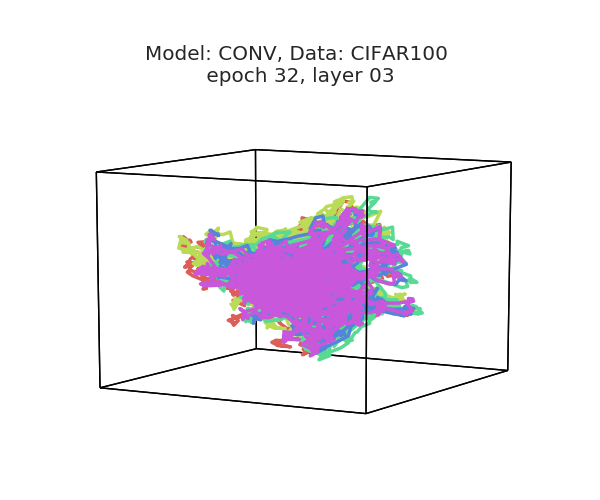

In [7]:
# # print some results if save
# save_path = None
# if save_animation: 
#     temp_plt_out_dir = '/tigress/qlu/logs/temp/hyp_nnsrm'
#     ani_fname = '%s_%s_e%d_l%d.mp4' % (
#         model_name.lower(), data_name.lower(), e, l)
#     save_path = os.path.join(temp_plt_out_dir, ani_fname)
#     print(save_path)

title_text = """
Model: %s, Data: %s \n epoch %.2d, layer %.2d 
""" % (model_name.upper(), data_name.upper(), e, 
       layer_names_plt[layer_selected.index(l)]) 

temp = hyp.plot(
    smoothed_acts[:n_nets_plot], 
    animate=True, 
    tail_duration = 1, frame_rate=60, rotations=.15, 
    title = title_text, 
#             save_path=save_path,
    size = (6, 5)
)